In [1]:
# https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

import pandas as pd
from collections import Counter
import numpy as np
from tqdm import tqdm
import requests
from IPython.display import HTML
import operator
import pickle
import os
import subprocess
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
from PIL import Image
import json

import torch
import torchvision
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
from torch.utils.data import Dataset, IterableDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import models, transforms

try:
  import albumentations
  albumentations.RandomResizedCrop
except:
  !pip install albumentations --upgrade
  import albumentations
from albumentations.pytorch import ToTensorV2

try:
  from efficientnet_pytorch import EfficientNet
except:
  !pip install efficientnet_pytorch
  from efficientnet_pytorch import EfficientNet

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

!cp "/content/gdrive/My Drive/PyTorch/utils/torch_wrapper.py" "/content"
from torch_wrapper import TorchWrapper
!cp "/content/gdrive/My Drive/PyTorch/utils/utils.py" "/content"
import utils
%load_ext autoreload
%autoreload 2

clear_output()

# Prepare Data

In [2]:
# Copy data from Drive

root = "/content/gdrive/My Drive/PyTorch/Kaggle/Cassava Leaf Disease/data/"
files_dict = {
    "train_images.zip": "/content/train_images",
    "train.csv": "/content/train.csv",
    "label_num_to_disease_map.json": "/content/label_num_to_disease_map.json"
}
for root_dir, target_dir in files_dict.items():
  if not os.path.exists(target_dir):
    if root_dir.endswith('.zip'):
      subprocess.call(['unzip', root+root_dir, '-d', target_dir])
    else:
      subprocess.call(['cp', root+root_dir, target_dir])
clear_output()

In [3]:
# Format data for the wrapper

train_labels = pd.read_csv('/content/train.csv')
train_labels_dict = dict(zip(train_labels['image_id'], train_labels['label'].astype(str)))
converted_train_labels_dict = json.loads(open('/content/label_num_to_disease_map.json', 'r').read())

X, y = [], []
for img_fname in tqdm(os.listdir('/content/train_images')):
  img_label = train_labels_dict[img_fname]
  converted_label = converted_train_labels_dict[img_label]
  X.append(img_fname)
  y.append(converted_label)

X = np.array(X)
y = np.array(y)

Counter(y)

100%|██████████| 21397/21397 [00:00<00:00, 876523.84it/s]


Counter({'Cassava Bacterial Blight (CBB)': 1087,
         'Cassava Brown Streak Disease (CBSD)': 2189,
         'Cassava Green Mottle (CGM)': 2386,
         'Cassava Mosaic Disease (CMD)': 13158,
         'Healthy': 2577})

# Load Data

In [7]:
class LeafDataset(Dataset):

  def __init__(self, x, y, device, transform):
    self.x = x
    self.y = y
    self.device = device
    self.transform = transform
    
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x = Image.open('/content/train_images/'+self.x[idx])
    x = self.transform(image=np.array(x))['image']

    x = x.float().to(self.device)
    y = torch.tensor(np.argmax(self.y[idx])).to(self.device).unsqueeze(0)

    return [x, y]

tfms = {
    'train': albumentations.Compose([
            albumentations.RandomResizedCrop(512, 512),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            albumentations.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.),
    'validation': albumentations.Compose([
            albumentations.CenterCrop(512, 512, p=1.),
            albumentations.Resize(512, 512),
            albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.),
    'inference': albumentations.Compose([
            albumentations.RandomResizedCrop(512, 512),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            albumentations.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
}

In [8]:
torch_wrapper = TorchWrapper(X, y, 
                             LeafDataset, transforms=tfms,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(32,32,32), num_workers=(0,0,0),
                             preprocess_data=True)

Data is split:
Training shape: ((17117,), (17117, 5))
Validation shape: ((2140,), (2140, 5))
Testing shape: ((2140,), (2140, 5))

Data is loaded into DataLoaders.


# Model

In [9]:
class LeafModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.effnet = EfficientNet.from_name("efficientnet-b4")
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1792, 5)

    def forward(self, image):
        batch_size, _, _, _ = image.shape
        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))
        return outputs
        
torch_wrapper.load_net(net=LeafModel(), weights='equal',
                       chosen_criterion=nn.CrossEntropyLoss, 
                       chosen_optimizer=optim.SGD,
                       chosen_optimizer_params={'lr':0.001, 'momentum':0.9})


Network is loaded.



In [10]:
# # TODO: learning rate decay scheduler
# # TODO: test-time augmentation

In [ ]:
torch_wrapper.train(epochs=5, log_mini_batches=10,
                    models_dir='/content/gdrive/My Drive/PyTorch/Kaggle/Cassava Leaf Disease/model_checkpoints')

# Evaluate

  0%|          | 0/535 [00:00<?, ?it/s]

Evaluating Train set...


/content/torch_wrapper.py:293: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = self.net(torch.tensor(inputs).float().to(self.device)).cpu().detach()
  0%|          | 0/34 [00:00<?, ?it/s]


Average Train Accuracy: 72.78%
Average Train Hit@N: 0.5

Evaluating Validation set...


  0%|          | 0/34 [00:00<?, ?it/s]


Average Validation Accuracy: 73.88%
Average Validation Hit@N: 0.5

Evaluating Test set...


100%|██████████| 34/34 [03:11<00:00,  5.63s/it]



Average Test Accuracy: 72.52%
Average Test Hit@N: 0.5



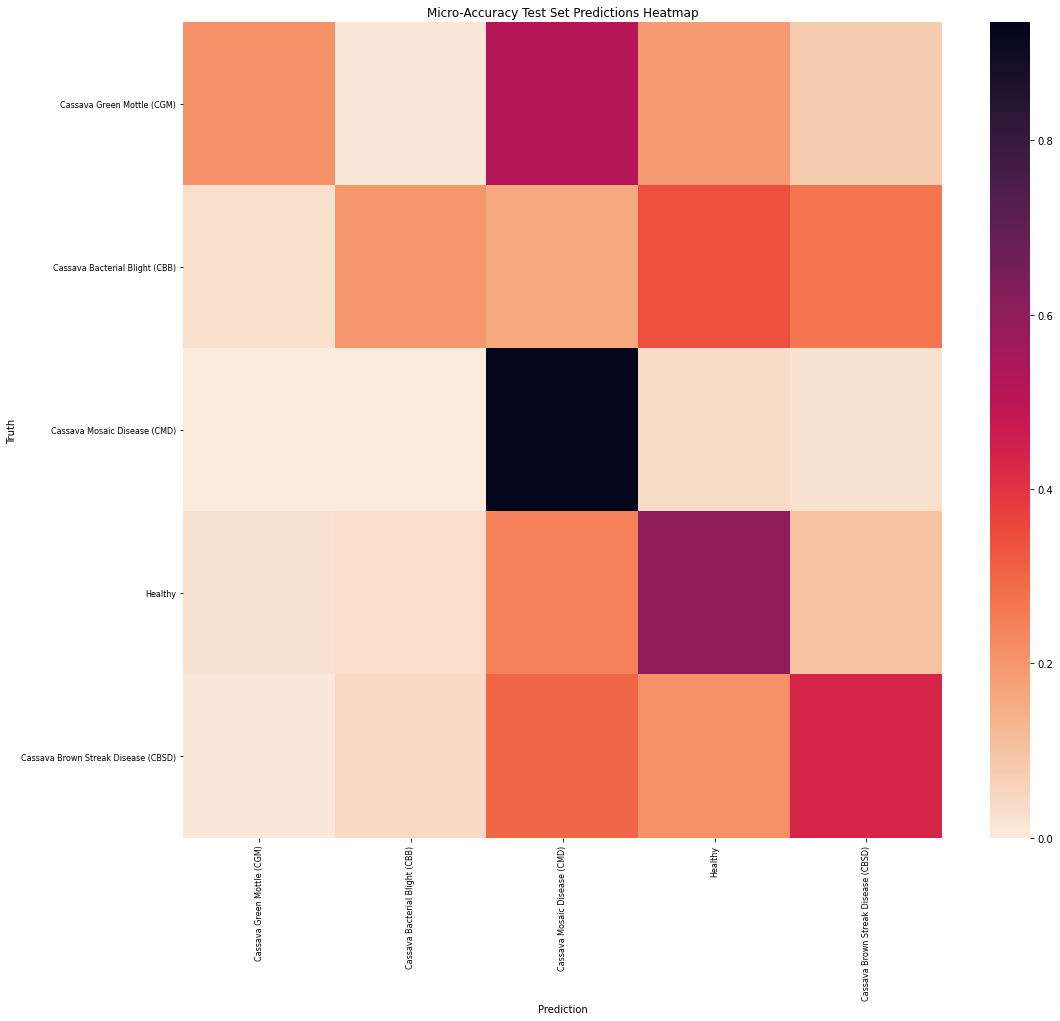

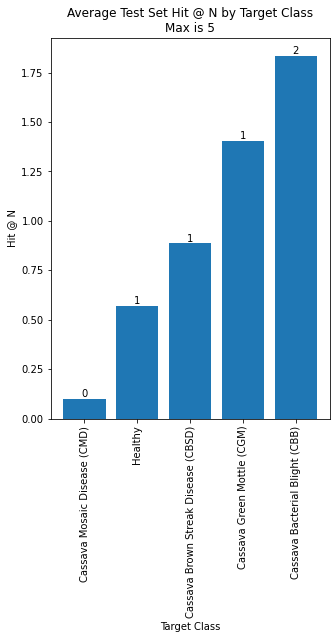

In [ ]:
torch_wrapper.evaluate()